In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import kruskal, spearmanr

# Path to your combined CSV
DATA_PATH = Path("data/combined_reviews_with_sentiment.csv")

df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()

(127546, 15)


,recommendationid,steamid,review,timestamp_created,timestamp_updated,voted_up,weighted_vote_score,playtime_forever,playtime_at_review,last_played,raw_json,playtime_hours,sentiment_compound,playtime_bucket,game_slug
0,212520779,76561198839172714,I honestly don’t know how I haven’t written a ...,1764819487,1764819487,1,0.5,4892,4892.0,1762675967,"{""recommendationid"": ""212520779"", ""author"": {""...",81.533333,0.9201,high,batman_arkham_city_game_of_the_year_edition
1,212513547,76561197960780012,Absolute mess.\n,1764809397,1764809397,0,0.5,109,109.0,1764809338,"{""recommendationid"": ""212513547"", ""author"": {""...",1.816667,-0.3612,low,batman_arkham_city_game_of_the_year_edition
2,212508126,76561198348575082,Arkham City\nThis game is such a massive step ...,1764802305,1764802305,1,0.5,2330,2330.0,1762007463,"{""recommendationid"": ""212508126"", ""author"": {""...",38.833333,0.9452,medium,batman_arkham_city_game_of_the_year_edition
3,212507565,76561199169548945,ta bien,1764801580,1764801580,1,0.5,988,930.0,1764805067,"{""recommendationid"": ""212507565"", ""author"": {""...",16.466667,0.0000,medium,batman_arkham_city_game_of_the_year_edition
4,212504392,76561198053469428,nice,1764797923,1764797923,1,0.5,1371,1371.0,1764797856,"{""recommendationid"": ""212504392"", ""author"": {""...",22.850000,0.4215,medium,batman_arkham_city_game_of_the_year_edition


In [ ]:
# Drop rows with missing review or sentiment
df = df.dropna(subset=["review", "sentiment_compound"])

# Ensure sentiment is numeric
df["sentiment_compound"] = pd.to_numeric(df["sentiment_compound"], errors="coerce")
df = df.dropna(subset=["sentiment_compound"])

df = df[df['sentiment_compound'] != 0.0]

# Make playtime_hours from playtime_forever (minutes) if needed
if "playtime_hours" not in df.columns:
    df["playtime_hours"] = df["playtime_forever"] / 60.0

# Remove obviously broken playtimes (e.g. negative)
df = df[df["playtime_hours"] >= 0]


df = df.dropna(subset=["playtime_bucket"])

df["playtime_bucket"].value_counts()


playtime_bucket
medium    55900
high      37302
low       10526
Name: count, dtype: int64

In [48]:
print(
    df.groupby("playtime_bucket")["sentiment_compound"]
      .agg(["count", "mean", "std", "median"])
      .sort_index()
)


                 count      mean       std  median
playtime_bucket                                   
high             37302  0.427754  0.541532  0.6249
low              10526  0.182462  0.601855  0.3612
medium           55900  0.383720  0.557657  0.5574


In [49]:
low_sent  = df.loc[df["playtime_bucket"] == "low", "sentiment_compound"]
med_sent  = df.loc[df["playtime_bucket"] == "medium", "sentiment_compound"]
high_sent = df.loc[df["playtime_bucket"] == "high", "sentiment_compound"]

stat, p_value = kruskal(low_sent, med_sent, high_sent)
print("Kruskal–Wallis H-stat:", stat)
print("p-value:", p_value)


Kruskal–Wallis H-stat: 1536.1828136405124
p-value: 0.0


In [59]:
# Optionally clip extreme playtimes to reduce weird outliers
df_corr = df.copy()
df_corr = df_corr[df_corr["playtime_hours"] <= 500]  # arbitrary cap, tweak as needed

rho, p_corr = spearmanr(df_corr["playtime_hours"], df_corr["sentiment_compound"])
print("Spearman correlation:", rho)
print("p-value:", p_corr)


Spearman correlation: 0.10944138732240065
p-value: 9.083036098156472e-269


<Figure size 600x400 with 0 Axes>

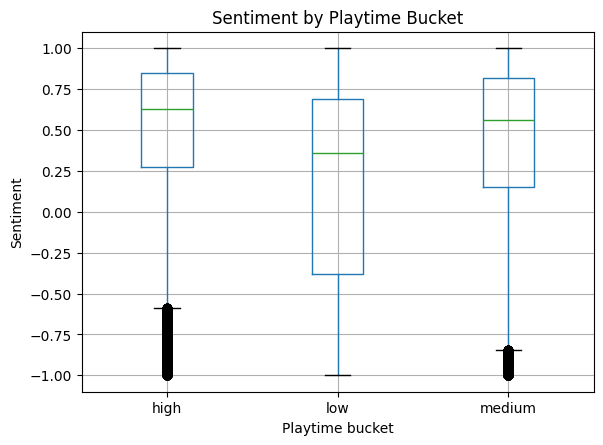

In [61]:
order = ["low", "medium", "high"]

plt.figure(figsize=(6, 4))
df.boxplot(column="sentiment_compound", by="playtime_bucket")
plt.title("Sentiment by Playtime Bucket")
plt.suptitle("")  # remove automatic super title
plt.xlabel("Playtime bucket")
plt.ylabel("Sentiment")
plt.show()


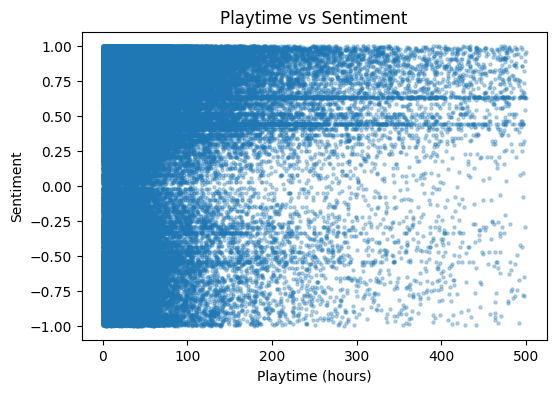

In [58]:
# Subsample for plotting if you have a huge dataset
plot_df = df_corr.sample(n=min(500000, len(df_corr)), random_state=0)

plt.figure(figsize=(6, 4))
plt.scatter(plot_df["playtime_hours"], plot_df["sentiment_compound"], alpha=0.3, s=5)
plt.xlabel("Playtime (hours)")
plt.ylabel("Sentiment")
plt.title("Playtime vs Sentiment")
plt.show()
